main issue:
- tangling and robustness are correlated in the wrong direction

try:
- r2_err instead of dtw_err for calculating robustness
- l2_norm penalty on `output`, i.e. state variable
- different hyperparam ranges...

# 0. Initial stuff

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np
import scipy.io as sio
import sklearn as sk

from sklearn import decomposition
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

# For jupyter tensorboarding
from io import BytesIO
from functools import partial
import PIL.Image
from ipywidgets import FloatProgress

from IPython.display import clear_output, Image, display, HTML

import pickle
import os
import pprint as pp

from dtw import dtw
from cdtw import pydtw

from tqdm import tqdm # progress bar

In [4]:
import cyclingrnn.geometric as geo
from cyclingrnn import sigerr
from cyclingrnn.train import *

In [5]:
# sns colormaps
#cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',5)[-2:]
#sns.set_palette(cmap)
sns.set_context('notebook', font_scale=1.0)

In [89]:
sns.color_palette("Set1")

[(0.89411765336990356, 0.10196078568696976, 0.10980392247438431),
 (0.21602460800432691, 0.49487120380588606, 0.71987698697576341),
 (0.30426760128900115, 0.68329106055054012, 0.29293349969620797),
 (0.60083047361934883, 0.30814303335021526, 0.63169552298153153),
 (1.0, 0.50591311045721465, 0.0031372549487095253),
 (0.99315647868549117, 0.9870049982678657, 0.19915417450315812)]

In [280]:
def giant_regplot(df, cols=None, rows=None, logs=[]):

  if not cols:
    cols = df.columns
    for col in cols:
      try:
        if len(df[col].unique())==1: # this returns an error when df[col] is an e.g. list
          df = df.drop(col, axis=1) # drop columns with all identical entries
      except:
        df = df.drop(col, axis=1) # if above returned an error, drop
    cols = df.columns # now we have our column set
  if not rows:
    rows = df.columns
  
  isnumeric_col = [np.any([isinstance(i, (int, long, float, complex)) for i in df[c]]) for c in cols]  
  isnumeric_row = [np.any([isinstance(i, (int, long, float, complex)) for i in df[r]]) for r in rows]  
  
  fact = 3
  num_cols, num_rows = len(cols), len(rows)
  f, ax = plt.subplots(num_rows, num_cols, figsize=(fact*num_cols, fact*num_rows), sharey=False, sharex=False)
  for ir, row in enumerate(rows):
    for ic, col,  in enumerate(cols):
      logx_bool = col in logs
      if logx_bool:
        ax[ir, ic].set_xscale('log', basex=10)
      logy_bool = row in logs
      if logy_bool:
        ax[ir, ic].set_yscale('log', basex=10)

      if np.logical_xor(isnumeric_row[ir], isnumeric_col[ic]):
        sns.violinplot(x=col, y=row, data=df, ax=ax[ir, ic])
      elif (isnumeric_row[ir] and isnumeric_col[ic]):
        #sns.regplot(col, row, df, logx=logx_bool, ax=ax[ir, ic], truncate=False)
        ax[ir, ic].scatter(df[col], df[row], c=df.activation=='linear', cmap=mplcmap)
        sns.regplot(col, row, df, logx=logx_bool and not logy_bool, ax=ax[ir, ic], truncate=False, scatter=False, color="0.2")
        d_range = df[row].max() - df[row].min()
        ax[ir, ic].set_ylim([df[row].min()-0.1*d_range, df[row].max()+0.1*d_range])
        ax[ir, ic].set_xlim([df[col].min(), df[col].max()])
        
        try:
          ax[ir, ic].axhline(m1_metrics[row], color='k')
          ax[ir, ic].axhline(emg_metrics[row], color='r')
        except:
          pass

      if ir < num_rows-1:
        ax[ir, ic].xaxis.label.set_visible(False)
      if ic > 0:
        ax[ir, ic].yaxis.label.set_visible(False)
        
  return f, ax


In [257]:
def evaluate_run(conds, monkey, m1_or_emg):
  # Get monkey
  # build input and output data
  if monkey == 'D':
    try:
      data = sio.loadmat('./drakeFeb_processed.mat') #TODO: fix, '../' or './' depending on whether running from wrapper or not
    except:
      data = sio.loadmat('../drakeFeb_processed.mat')
  elif monkey == 'C':
    try:
      data = sio.loadmat('./cousFeb_processed.mat')
    except:
      data = sio.loadmat('../cousFeb_processed.mat')
  
  emg = data['EMG']
  m1 = data['M1']

  m1_ = m1[:, conds, :]
  emg_ = emg[:, conds, :]

  if m1_or_emg == 'm1':
    array = m1_
  elif m1_or_emg == 'emg':
    array = emg_
  
  mets = dict()
  R2 = 1.

  mets['sim_num'] = 0

  mets['tangling_90_01']  = geo.tangling_cdf( array, cutoff=0.90, alpha=0.1  )
  mets['tangling_90_001'] = geo.tangling_cdf( array, cutoff=0.90, alpha=0.01 )
  mets['tangling_95_01']  = geo.tangling_cdf( array, cutoff=0.95, alpha=0.1  )
  mets['tangling_95_001'] = geo.tangling_cdf( array, cutoff=0.95, alpha=0.01 )

  mets['path_length'] = np.sum(geo.get_path_length(array, filt_freq=0.25))
  mets['mean_curvature'], mets['mean_torsion'], _ = geo.mean_curvature(array, total_points=11, deg=4, normalize=True)
  
  mets['MSE'] = 0.
  mets['R2'] = R2

  mets['noise_robustness'], mets['struct_robustness'] = 0., 0.
    
  return mets


# Visualize results

In [299]:
df_path = '../saves/170301D/df0123.pickle'
df = pickle.load(open(df_path))

conds = [0,1,2,3]
monkey = 'D'

m1_metrics = evaluate_run(conds, monkey, 'm1')
emg_metrics = evaluate_run(conds, monkey, 'emg')

In [300]:
df = df[df.activation == 'tanh']
df = df[df.num_neurons == 100]
#df = df[df.MSE < 0.006]
df = df[df.tangling_95_01 < 4000]
df = df[df.mean_curvature < 400]

In [301]:
df.columns

Index([u'activation', u'beta1', u'beta2', u'learning_rate', u'monkey',
       u'num_neurons', u'rnn_init', u'stddev_out', u'stddev_state', u'MSE',
       u'R2', u'noise_robustness', u'path_length', u'percent_tangling1_001',
       u'percent_tangling1_01', u'percent_tangling2_001',
       u'percent_tangling2_01', u'percent_tangling3_001',
       u'percent_tangling3_01', u'sim_num', u'struct_robustness',
       u'tangling_90_001', u'tangling_90_01', u'tangling_95_001',
       u'tangling_95_01', u'mean_curvature', u'mean_torsion'],
      dtype='object')

In [302]:
cols = ['beta1', 'beta2', 'stddev_state', 'learning_rate', 'rnn_init', 'activation']
rows = ['tangling_95_01', 'tangling_90_01', 'struct_robustness', 'noise_robustness', 'mean_curvature', 'mean_torsion', 'path_length']
logs = ['beta1', 'beta2', 'stddev_state', 'learning_rate', 'noise_robustness', 'struct_robustness']

In [303]:
import matplotlib as mpl

In [304]:
mplcmap = mpl.colors.ListedColormap(sns.color_palette().as_hex()[:2])

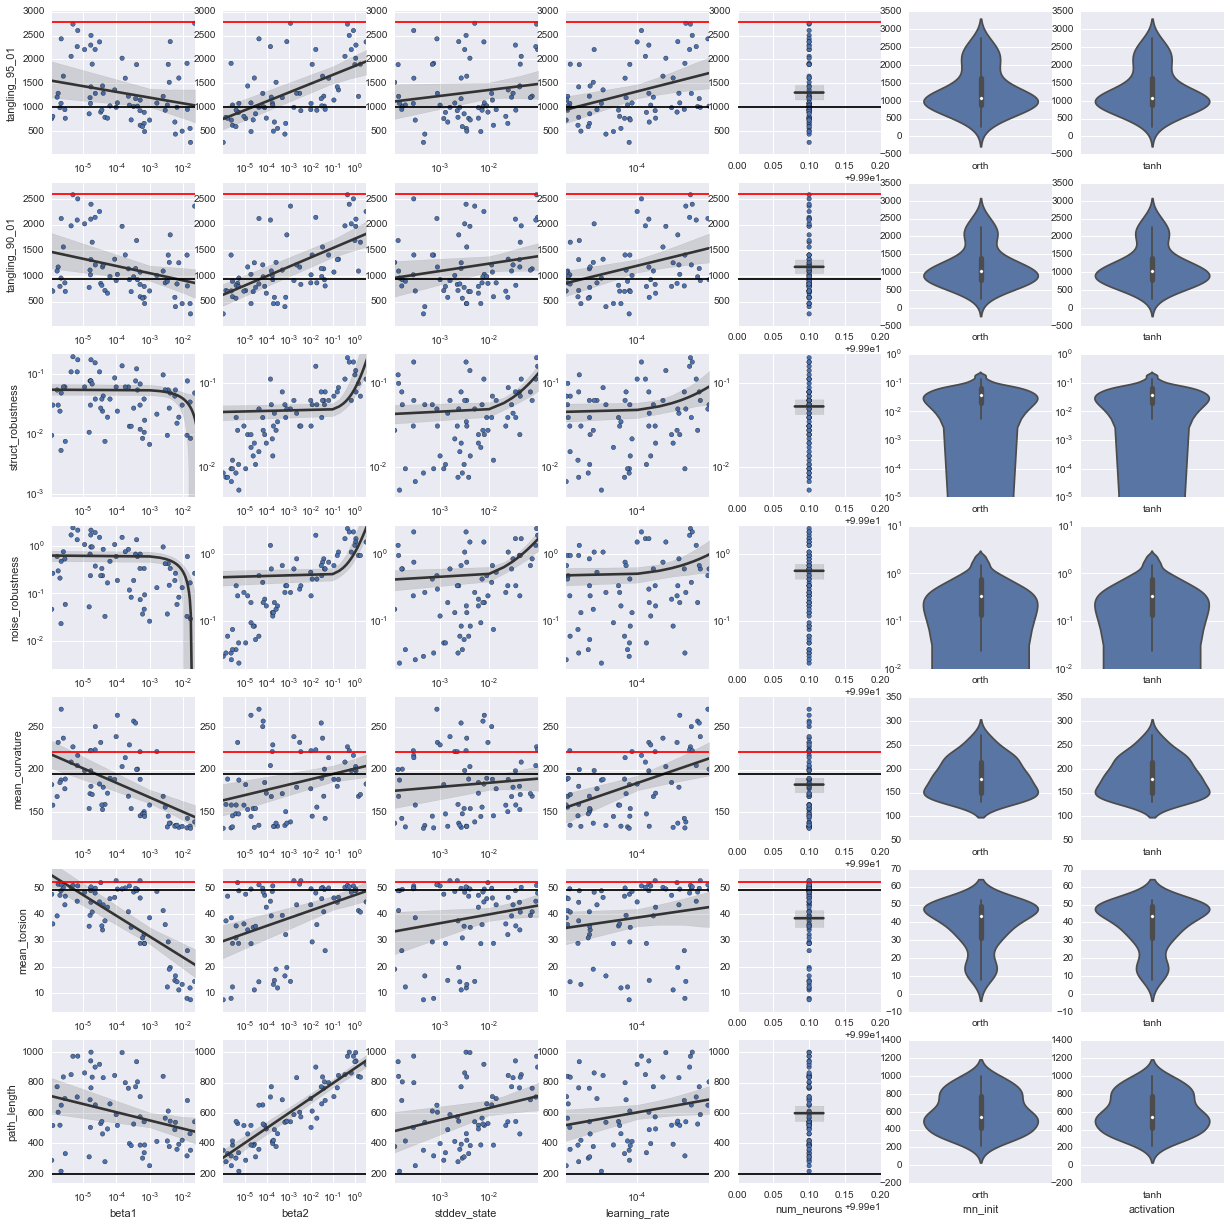

In [305]:
f, ax = giant_regplot(df, cols, rows, logs)

------------

In [306]:
cols = ['struct_robustness','noise_robustness']
rows = [u'tangling_90_01', u'tangling_95_01']

logs = ['struct_robustness','noise_robustness']

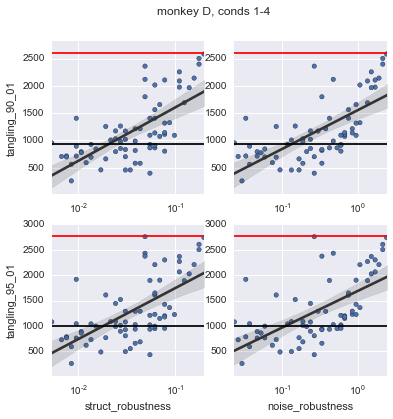

In [307]:
f, ax = giant_regplot(df, cols, rows, logs)
f.suptitle('monkey D, conds 1-4')

In [311]:
print df.struct_robustness.min()
print df.struct_robustness.max()

0.00533669923121
0.196304065004


In [99]:
# pick good RNNs
i1 = df.activation == 'tanh'
i2 = df.tangling_95_01 < m1_metrics['tangling_95_01'] + 200# and df.tangling_95_01 > (m1_metrics['tangling_95_01'] - 300)
i3 = df.tangling_95_01 > m1_metrics['tangling_95_01'] - 200

i4 = df.mean_curvature < m1_metrics['mean_curvature'] + 50# and df.tangling_95_01 > (m1_metrics['tangling_95_01'] - 300)
i5 = df.mean_curvature > m1_metrics['mean_curvature'] - 50

In [100]:
df_ = df[i1 & i2 & i3 & i4 & i5]

In [55]:
df_.sim_num

0      248
2      121
4      168
5      163
6      285
11      72
15     106
17     228
19     223
24       5
26     218
27     185
30     180
33       9
39     297
41      40
44     292
46     245
52     160
53      62
55     282
58     155
60      84
61     108
63     300
64     197
65     103
68      98
73     215
74     182
      ... 
131    161
135    151
136     90
139      8
141     44
145     66
150     94
153     12
156    259
161    249
162     56
165     77
173     99
177    186
178     17
179    134
180     24
181    256
182     31
188     39
190     46
192     60
201     89
203    198
207    193
212    263
216    211
217     21
218    131
222    201
Name: sim_num, dtype: int64